In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [81]:
def generate_property():
    """
    E/I: 1, bool
    blocked_in_stat: 1, bool
    I_external_Input: 1, float
    sub_blocak_idx: 1, int
    C: 1, float
    T_ref: 1, float
    g_Li: 1, float
    V_L: 1, float
    V_th: 1, float
    V_reset: 1, float
    g_ui: 4, float
    V_ui: 4, float
    tau_ui: 4, float
    
    total: 22
    """
    
    property = np.zeros((1,22), dtype=np.float32)
    
    
    property[:, 0] = 1 # E/I
    property[:, 1] = 0 # blocked_in_stat
    property[:, 2] = 0 # I_external_Input
    property[:, 3] = 0 # sub_blocak_idx
    property[:, 4] = 1 # C
    property[:, 5] = 5 # T_ref
    property[:, 6] = 0.001 # g_Li
    property[:, 7] = -75 # V_L
    property[:, 8] = -55 # V_th
    property[:, 9] = -65 # V_reset

    property[:, 10:14] = np.array([5/275, 5/4000, 1.5/30, 1.5/730]) # g_ui
    property[:, 14:18] = np.array([0, 0, -70, -100]) # V_ui
    property[:, 18:22] = np.array([2, 40, 10, 50]) # tau_ui
    

    return property

In [92]:
class block:
    def __init__(self, node_property, delta_t=1):
        # A block is a set of spliking neurals with inner full connections, we consider 4 connections:
        # AMPA, NMDA, GABAa and GABAb
        # shape note:
        #
        # N: numbers of neural cells
        # K: connections kind, = 4 (AMPA, NMDA, GABAa and GABAb)
        
        import torch
        
        N = 1
        K = 4
        
        self.delta_t = delta_t
        
        self.I_extern_Input = torch.tensor(node_property[:, 2]) # extern_input index , shape[K]
        self.sub_idx = torch.tensor(node_property[:, 3]) # shape [N]
        self.C = torch.tensor(node_property[:, 4])   # shape [N]
        self.T_ref = torch.tensor(node_property[:, 5]) # shape [N]
        self.g_Li = torch.tensor(node_property[:, 6])  # shape [N]
        self.V_L = torch.tensor(node_property[:, 7])  # shape [N]        
        self.V_th = torch.tensor(node_property[:, 8])  # shape [N]
        self.V_reset = torch.tensor(node_property[:, 9]) # shape [N]
        self.g_ui = torch.tensor(node_property[:, 10:14].reshape([4,1])) # shape [K, N]
        self.V_ui =torch.tensor(node_property[:, 14:18].reshape([4,1]))  # AMPA, NMDA, GABAa and GABAb potential, shape [K, N]
        self.tau_ui = torch.tensor(node_property[:, 18:22].reshape([4,1]))# shape [K, N]   

        self.t_ik_last = torch.zeros(N) # shape [N]
        self.active = torch.tensor(False) # bool
        self.V_i = torch.ones(N) * (self.V_th + self.V_reset)/2  # membrane potential, shape: [N]
        self.J_ui = torch.zeros((K, N))  # shape [K, N]
        self.t = torch.tensor(0.)  # scalar

    def update_J_ui(self, spikes):
        # spikes: num of spike
        
        J_ui_activate_part = torch.ones(4,1) * spikes
        self.J_ui = self.J_ui * torch.exp(-self.delta_t / self.tau_ui)
        self.J_ui += J_ui_activate_part

    def update_t_ik_last(self):
        self.t_ik_last = torch.where(self.active, self.t, self.t_ik_last)

    def update_Vi(self):
        
        I_ui = self.g_ui * (self.V_ui - self.V_i) * self.J_ui
        print(f'I_ui: {I_ui}')
        I_syn = I_ui.sum(dim=0)
        print(f'I_syn: {I_syn}')
        
        delta_Vi = -self.g_Li * (self.V_i - self.V_L) + I_syn + self.I_extern_Input
        delta_Vi *= self.delta_t / self.C
        print(f'delta_Vi: {delta_Vi}')
        Vi_normal = self.V_i + delta_Vi

        is_not_saturated = (self.t >= self.t_ik_last + self.T_ref)
        self.V_i = torch.where(is_not_saturated, Vi_normal, self.V_reset)
        self.active = self.V_i >= self.V_th
        self.V_i = torch.min(self.V_i, self.V_th)

    def update(self, spikes):
        self.t += self.delta_t
        
        self.update_J_ui(spikes)
        self.update_t_ik_last()
        self.update_Vi()

        return self.t.tolist(), self.V_i.tolist()[0]
    
    def param_show(self):
        print(f'I_extern_Input: {self.I_extern_Input}')
        print(f'sub_idx: {self.sub_idx}')
        print(f'C: {self.C}')
        print(f'T_ref: {self.T_ref}')
        print(f'g_Li: {self.g_Li}')
        print(f'V_L: {self.V_L}')        
        print(f'V_th: {self.V_th}')
        print(f'V_reset: {self.V_reset}')
        print(f'g_ui: {self.g_ui}')
        print(f'V_ui: {self.V_ui}')
        print(f'tau_ui: {self.tau_ui}')  

        print(f't_ik_last: {self.t_ik_last}')
        print(f'active: {self.active}')
        print(f'V_i: {self.V_i}')
        print(f'J_ui: {self.J_ui}')
        print(f't: {self.t}')

In [93]:
t = 1000 #ms
sp = torch.poisson(torch.ones(t)*2)
pro = generate_property()
b = block(pro, delta_t=100)

In [94]:
x_out = []
y_out = []
for i in range(t):
    x, y = b.update(sp[i])
    x_out.append(x)
    y_out.append(y)

I_ui: tensor([[ 1.0909],
        [ 0.0750],
        [-0.5000],
        [-0.0822]])
I_syn: tensor([0.5837])
delta_Vi: tensor([56.8717])
I_ui: tensor([[ 4.0000],
        [ 0.2806],
        [-3.0000],
        [-0.3824]])
I_syn: tensor([0.8982])
delta_Vi: tensor([87.8232])
I_ui: tensor([[ 1.1818],
        [ 0.1085],
        [-0.2500],
        [-0.1122]])
I_syn: tensor([0.9281])
delta_Vi: tensor([91.8081])
I_ui: tensor([[ 1.0000],
        [ 0.0763],
        [-0.7500],
        [-0.1120]])
I_syn: tensor([0.2143])
delta_Vi: tensor([19.4267])
I_ui: tensor([[ 3.5455],
        [ 0.2512],
        [-0.7500],
        [-0.2275]])
I_syn: tensor([2.8191])
delta_Vi: tensor([280.9053])
I_ui: tensor([[ 1.0000],
        [ 0.0862],
        [-0.7501],
        [-0.1321]])
I_syn: tensor([0.2040])
delta_Vi: tensor([18.4033])
I_ui: tensor([[ 3.5455],
        [ 0.2521],
        [-0.7500],
        [-0.2297]])
I_syn: tensor([2.8179])
delta_Vi: tensor([280.7901])
I_ui: tensor([[ 2.0000],
        [ 0.1550],
        [

I_syn: tensor([2.8213])
delta_Vi: tensor([281.1333])
I_ui: tensor([[ 1.0000],
        [ 0.0858],
        [-0.7501],
        [-0.1306]])
I_syn: tensor([0.2051])
delta_Vi: tensor([18.5068])
I_ui: tensor([[ 1.1818],
        [ 0.0896],
        [-0.2500],
        [-0.0857]])
I_syn: tensor([0.9357])
delta_Vi: tensor([92.5712])
I_ui: tensor([[ 2.0000],
        [ 0.1437],
        [-1.5000],
        [-0.1998]])
I_syn: tensor([0.4438])
delta_Vi: tensor([42.3850])
I_ui: tensor([[ 4.5589e-22],
        [ 1.3942e-02],
        [-2.2700e-05],
        [-2.1035e-02]])
I_syn: tensor([-0.0071])
delta_Vi: tensor([-1.7115])
I_ui: tensor([[ 6.0647],
        [ 0.4181],
        [-0.8221],
        [-0.3447]])
I_syn: tensor([5.3160])
delta_Vi: tensor([530.7691])
I_ui: tensor([[ 1.0000],
        [ 0.0970],
        [-0.7502],
        [-0.1555]])
I_syn: tensor([0.1913])
delta_Vi: tensor([17.1345])
I_ui: tensor([[ 1.1818],
        [ 0.0907],
        [-0.2500],
        [-0.0883]])
I_syn: tensor([0.9342])
delta_Vi: te

        [-0.3182]])
I_syn: tensor([3.7546])
delta_Vi: tensor([374.4583])
I_ui: tensor([[ 1.0000],
        [ 0.0928],
        [-0.7501],
        [-0.1478]])
I_syn: tensor([0.1948])
delta_Vi: tensor([17.4779])
I_ui: tensor([[ 1.1818],
        [ 0.0902],
        [-0.2500],
        [-0.0875]])
I_syn: tensor([0.9346])
delta_Vi: tensor([92.4575])
I_ui: tensor([[ 4.0000],
        [ 0.2813],
        [-3.0000],
        [-0.3851]])
I_syn: tensor([0.8961])
delta_Vi: tensor([87.6150])
I_ui: tensor([[ 9.1177e-22],
        [ 2.7286e-02],
        [-4.5400e-05],
        [-4.0534e-02]])
I_syn: tensor([-0.0133])
delta_Vi: tensor([-2.3294])
I_ui: tensor([[ 1.2242],
        [ 0.0865],
        [-0.1335],
        [-0.0723]])
I_syn: tensor([1.1049])
delta_Vi: tensor([109.7200])
I_ui: tensor([[ 3.0000],
        [ 0.2120],
        [-2.2500],
        [-0.2909]])
I_syn: tensor([0.6711])
delta_Vi: tensor([65.1149])
I_ui: tensor([[ 4.7273],
        [ 0.3456],
        [-1.0000],
        [-0.3183]])
I_syn: tensor([3

delta_Vi: tensor([108.9980])
I_ui: tensor([[ 1.1397e-21],
        [ 3.5002e-02],
        [-5.6751e-05],
        [-5.2707e-02]])
I_syn: tensor([-0.0178])
delta_Vi: tensor([-2.7762])
I_ui: tensor([[ 9.8584],
        [ 0.6808],
        [-0.8895],
        [-0.5363]])
I_syn: tensor([9.1133])
delta_Vi: tensor([910.6079])
I_ui: tensor([[ 1.5430e-21],
        [ 4.5346e-02],
        [-2.7240e-04],
        [-1.0135e-01]])
I_syn: tensor([-0.0563])
delta_Vi: tensor([-7.6278])
I_ui: tensor([[ 7.0909],
        [ 0.4919],
        [-1.5000],
        [-0.4422]])
I_syn: tensor([5.6406])
delta_Vi: tensor([563.0632])
I_ui: tensor([[ 1.0000],
        [ 0.1029],
        [-0.7502],
        [-0.1694]])
I_syn: tensor([0.1833])
delta_Vi: tensor([16.3306])
I_ui: tensor([[ 1.1818],
        [ 0.0912],
        [-0.2500],
        [-0.0897]])
I_syn: tensor([0.9333])
delta_Vi: tensor([92.3291])
I_ui: tensor([[ 2.0000],
        [ 0.1438],
        [-1.5000],
        [-0.2005]])
I_syn: tensor([0.4433])
delta_Vi: tensor([

I_ui: tensor([[ 3.5455],
        [ 0.2588],
        [-0.7500],
        [-0.2394]])
I_syn: tensor([2.8148])
delta_Vi: tensor([280.4828])
I_ui: tensor([[ 1.0000],
        [ 0.0867],
        [-0.7501],
        [-0.1341]])
I_syn: tensor([0.2025])
delta_Vi: tensor([18.2502])
I_ui: tensor([[ 1.1818],
        [ 0.0897],
        [-0.2500],
        [-0.0860]])
I_syn: tensor([0.9354])
delta_Vi: tensor([92.5434])
I_ui: tensor([[ 1.0000],
        [ 0.0750],
        [-0.7500],
        [-0.1074]])
I_syn: tensor([0.2175])
delta_Vi: tensor([19.7507])
I_ui: tensor([[ 2.3636],
        [ 0.1698],
        [-0.5000],
        [-0.1551]])
I_syn: tensor([1.8783])
delta_Vi: tensor([186.8254])
I_ui: tensor([[ 3.0000],
        [ 0.2180],
        [-2.2501],
        [-0.3044]])
I_syn: tensor([0.6636])
delta_Vi: tensor([64.3581])
I_ui: tensor([[ 5.9091],
        [ 0.4274],
        [-1.2500],
        [-0.3916]])
I_syn: tensor([4.6948])
delta_Vi: tensor([468.4828])
I_ui: tensor([[ 4.0000],
        [ 0.3047],
        

I_syn: tensor([4.6956])
delta_Vi: tensor([468.5578])
I_ui: tensor([[ 2.0000],
        [ 0.1671],
        [-1.5002],
        [-0.2529]])
I_syn: tensor([0.4141])
delta_Vi: tensor([39.4127])
I_ui: tensor([[ 1.1818],
        [ 0.0975],
        [-0.2500],
        [-0.0985]])
I_syn: tensor([0.9307])
delta_Vi: tensor([92.0727])
I_ui: tensor([[ 3.0000],
        [ 0.2130],
        [-2.2500],
        [-0.2945]])
I_syn: tensor([0.6684])
delta_Vi: tensor([64.8443])
I_ui: tensor([[ 1.1818],
        [ 0.1019],
        [-0.2500],
        [-0.1029]])
I_syn: tensor([0.9308])
delta_Vi: tensor([92.0777])
I_ui: tensor([[ 1.0000],
        [ 0.0758],
        [-0.7500],
        [-0.1104]])
I_syn: tensor([0.2154])
delta_Vi: tensor([19.5420])
I_ui: tensor([[ 2.2794e-22],
        [ 7.3561e-03],
        [-1.1350e-05],
        [-1.1618e-02]])
I_syn: tensor([-0.0043])
delta_Vi: tensor([-1.4273])
I_ui: tensor([[ 3.6233],
        [ 0.2497],
        [-0.5359],
        [-0.2085]])
I_syn: tensor([3.1287])
delta_Vi: ten

I_syn: tensor([0.4417])
delta_Vi: tensor([42.1750])
I_ui: tensor([[ 1.1818],
        [ 0.0953],
        [-0.2500],
        [-0.0933]])
I_syn: tensor([0.9338])
delta_Vi: tensor([92.3807])
I_ui: tensor([[ 4.0000],
        [ 0.2816],
        [-3.0000],
        [-0.3861]])
I_syn: tensor([0.8955])
delta_Vi: tensor([87.5492])
I_ui: tensor([[ 2.3636],
        [ 0.1898],
        [-0.5000],
        [-0.1845]])
I_syn: tensor([1.8689])
delta_Vi: tensor([185.8935])
I_ui: tensor([[ 1.0000],
        [ 0.0819],
        [-0.7501],
        [-0.1246]])
I_syn: tensor([0.2073])
delta_Vi: tensor([18.7301])
I_ui: tensor([[ 2.3636],
        [ 0.1704],
        [-0.5000],
        [-0.1569]])
I_syn: tensor([1.8771])
delta_Vi: tensor([186.7126])
I_ui: tensor([[ 1.0000],
        [ 0.0806],
        [-0.7501],
        [-0.1198]])
I_syn: tensor([0.2107])
delta_Vi: tensor([19.0746])
I_ui: tensor([[ 1.1818],
        [ 0.0891],
        [-0.2500],
        [-0.0845]])
I_syn: tensor([0.9363])
delta_Vi: tensor([92.6349])
I

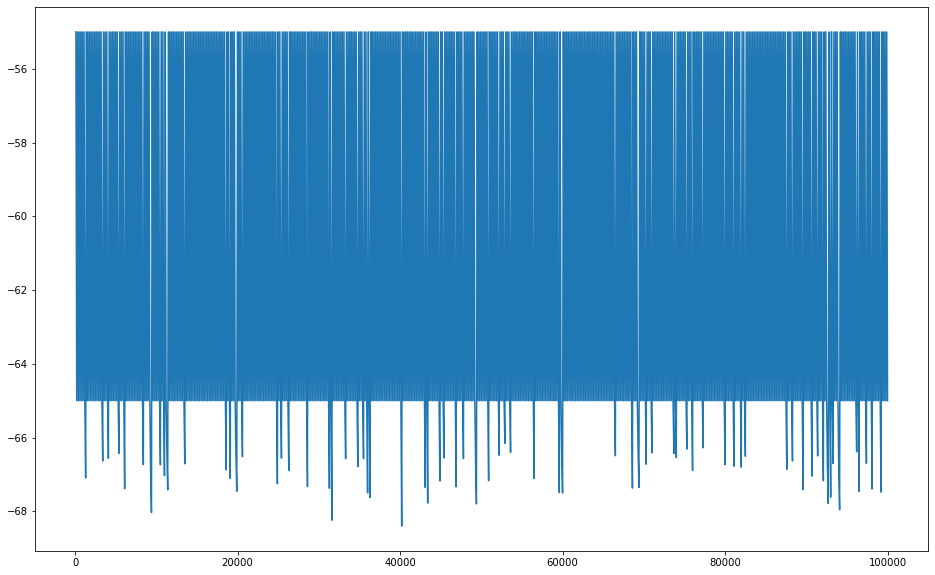

In [95]:
plt.subplots(figsize=(16, 10))
plt.plot(x_out,y_out)  #画图
plt.show()#loss函数图